# Modelado: XGBOOST


### Carga de librerías

In [13]:
import pandas as pd
import numpy as np
# Import mlflow for models tracking
import mlflow
# Libraries for models and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, f1_score, precision_score, recall_score
import xgboost as xgb
# Visualization libraries
import matplotlib.pyplot as plt

# Packages to manage class imbalance
from collections import Counter
from imblearn.over_sampling import SMOTE


### Carga de ficheros

In [6]:
df = pd.read_csv("../../data/final/df_train_final.csv")
df.head(5)

,TARGET,DAYS_BIRTH,EXT_SOURCE_3,EXT_SOURCE_1,EXT_SOURCE_2,QTY_ACTIVE_BUREAU,QTY_APP_LAST_YEAR,RATIO_NONAPPROVED
0,1,-9461,0.139376,0.083037,0.262949,2.0,1.0,0.0
1,0,-16765,0.507626,0.311267,0.622246,1.0,0.0,0.0
2,0,-13778,0.492060,0.774761,0.724000,4.0,1.0,0.0
3,0,-10197,0.363945,0.319760,0.651862,2.0,0.0,0.0
4,0,-13439,0.176653,0.464831,0.715042,4.0,4.0,0.0


### Dataset final

#### Preparación datasets train and test

In [22]:
# Separate TARGET variable from dependent variables
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Divide dataset in train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Generate expermient tracking in MLflow
exp_name = 'Model XGBoost'
exp_id = mlflow.create_experiment(name=exp_name)

#### Prueba Nro. 1

In [ ]:
# Track each run
with mlflow.start_run(experiment_id=exp_id, run_name="XGBoost - mlogloss"):
    # Create and train XGBoost model
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    trained_model = model.fit(X_train, y_train)

    # Evaluate predictions in test dataset of positive class to calculate AUC
    y_pred_auc = trained_model.predict_proba(X_test)[:, 1]
    # Evaluate model for accuracy metric
    y_pred = trained_model.predict(X_test)

    # Classes distribution
    class_distribution = np.bincount(y_pred, minlength=len(np.unique(y)))
    class_distribution_percentage = (class_distribution / len(y_pred)) * 100

    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_auc)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)


    # Track evaluation metric used for the model
    mlflow.log_param('eval_metric', 'logloss')

    # Track metrics
    mlflow.log_metric('roc_auc_score', auc_score)
    mlflow.log_metric('accuracy_score', accuracy)
    mlflow.log_metric('precision_score', precision)
    mlflow.log_metric('recall_score', recall)
    mlflow.log_metric('f1_score', f1)

    # Save model
    mlflow.sklearn.log_model(trained_model, "XGBoost - logloss")

    # Close MLflow tracking
    mlflow.end_run()

# Print results
print("Distribución final de clases (conteo):", class_distribution)
print("Distribución final de clases (porcentaje):", class_distribution_percentage)

print(f"AUC: {auc_score:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

c:\Users\elisa\OneDrive\MÁSTER\TFM\VIU_TFM\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:56:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2024/11/25 11:56:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Distribución final de clases (conteo): [59042   163]
Distribución final de clases (porcentaje): [99.72468542  0.27531458]
AUC: 0.7237
Accuracy: 92.54%
Precision: 0.3804
Recall: 0.0142
F1-Score: 0.0273
Confusion Matrix:
[[54726   101]
 [ 4316    62]]


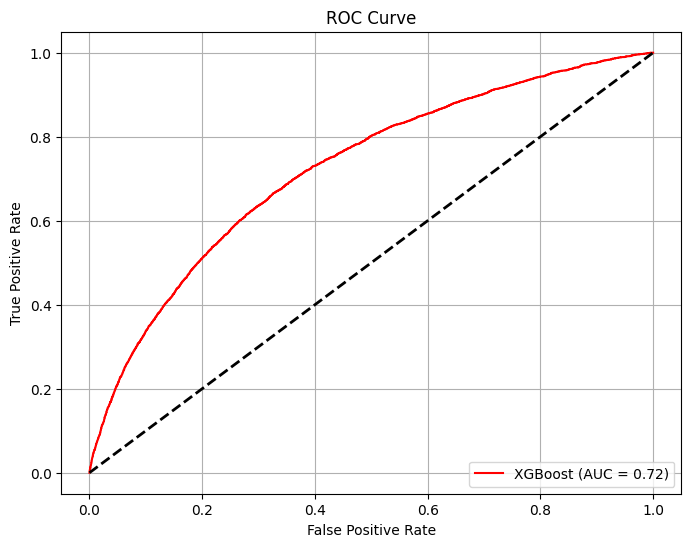

In [24]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_auc)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_score:.2f})", color='red')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

El valor AUC es 0.72 y la precisión (accurracy) es muy cercana a 1. Esto puede ser causado por tener clases desbalanceadas o que el modelo esté sesgado hacia la clase mayoritaria.

In [25]:
df_grouped_target= df.groupby('TARGET').size().reset_index(name='COUNT')
df_grouped_target

,TARGET,COUNT
0,0,182905
1,1,14442


<Axes: xlabel='TARGET'>

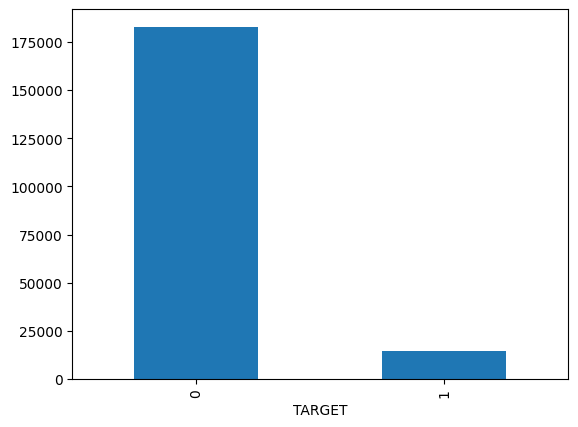

In [26]:
# Plotting a bar plot for TARGET
#plt.bar(df_grouped_target['TARGET'], df_grouped_target['COUNT'],  color='skyblue', edgecolor='black')
df_grouped_target.plot.bar(x='TARGET', y='COUNT', legend=False) 
# Adding labels and title
#plt.xlabel('Target Values')
#plt.ylabel('Count')
#plt.title('Distribution of TARGET class')
 
# Display the plot
#plt.show()

In [27]:
percentage_1=round(100*df_grouped_target[df_grouped_target['TARGET']==1]['COUNT'].values[0]/len(df),2)
print(f"La clase 1 representa un {percentage_1}% de la muestra.")

La clase 1 representa un 7.32% de la muestra.


#### Prueba Nro. 2 

Tratando el desbalanceo de clases. Se uttiliza el hiperparametro scale_pos_weight para ajustar el peso de las clases

In [36]:
# Track each run
with mlflow.start_run(experiment_id=exp_id, run_name="XGBoost - class weighting"):

    # Count classes distribution over train dataset
    class_distr = Counter(y_train)
    # Adjust weights to minority class
    scale_pos_weight = class_distr[0] / class_distr[1]

    # Create and train XGBoost model
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42)
    trained_model = model.fit(X_train, y_train)

    # Evaluate predictions in test dataset of positive class to calculate AUC
    y_pred_auc = trained_model.predict_proba(X_test)[:, 1]
    # Evaluate model for accuracy metric
    y_pred = trained_model.predict(X_test)

    # Classes distribution
    class_distribution = np.bincount(y_pred, minlength=len(np.unique(y)))
    class_distribution_percentage = (class_distribution / len(y_pred)) * 100

    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_auc)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)


    # Track evaluation metric used for the model
    mlflow.log_param('eval_metric', 'logloss')
    mlflow.log_param('scale_pos_weight', scale_pos_weight)

    # Track metrics
    mlflow.log_metric('roc_auc_score', auc_score)
    mlflow.log_metric('accuracy_score', accuracy)
    mlflow.log_metric('precision_score', precision)
    mlflow.log_metric('recall_score', recall)
    mlflow.log_metric('f1_score', f1)

    # Save model
    mlflow.sklearn.log_model(trained_model, "XGBoost - class weighting")

    # Close MLflow tracking
    mlflow.end_run()

# Print results
print("Distribución final de clases (conteo):", class_distribution)
print("Distribución final de clases (porcentaje):", class_distribution_percentage)

print(f"scale_pos_weight: {scale_pos_weight}")
print(f"AUC: {auc_score:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

c:\Users\elisa\OneDrive\MÁSTER\TFM\VIU_TFM\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:14:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2024/12/02 13:14:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Distribución final de clases (conteo): [42053 17152]
Distribución final de clases (porcentaje): [71.02947386 28.97052614]
scale_pos_weight: 12.72635135135135
AUC: 0.7101
Accuracy: 72.09%
Precision: 0.1459
Recall: 0.5717
F1-Score: 0.2325
Confusion Matrix:
[[40178 14649]
 [ 1875  2503]]


El AUC se ha reducido ligeramente pero aún así muestra un rendimiento moderado. No obstante, la métrica accuracy se ha visto significamente reducida. Observando F1 Score, se concluye que el ajuste del peso de las clases ha contribuido significativamente al rendimiento del modelo.

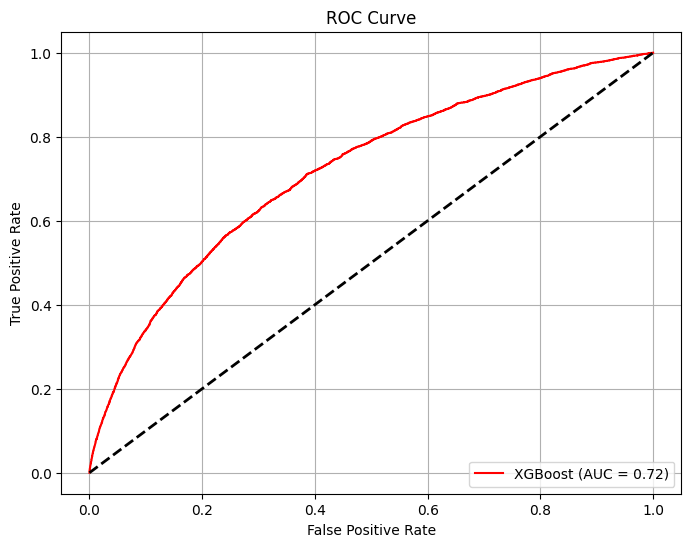

In [29]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_auc)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_score:.2f})", color='red')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Prueba Nro. 3

Tratando el desbalanceo de clases con SMOTE.

In [35]:
# Track each run
with mlflow.start_run(experiment_id=exp_id, run_name="XGBoost - SMOTE"):

    # Original class distribution
    print(f"Original class distribution: {np.bincount(y_train)}")

    # Apply SMOTE to create synthetic instances for the minority class
    smote = SMOTE(random_state=42)
   
    # Create train and test based on SMOTE sample to avoid overfitting on test sample
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # SMOTE class distribution
    print(f"SMOTE class distribution: {np.bincount(y_train_smote)}")

    # Create and train XGBoost model
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    trained_model = model.fit(X_train_smote, y_train_smote )

    # Evaluate predictions in test dataset of positive class to calculate AUC
    y_pred_auc = trained_model.predict_proba(X_test)[:, 1]
    # Evaluate model for accuracy metric
    y_pred = trained_model.predict(X_test)

    # Classes distribution
    class_distribution = np.bincount(y_pred, minlength=len(np.unique(y)))
    class_distribution_percentage = (class_distribution / len(y_pred)) * 100

    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_auc)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)


    # Track evaluation metric used for the model
    mlflow.log_param('eval_metric', 'logloss')

    # Track metrics
    mlflow.log_metric('roc_auc_score', auc_score)
    mlflow.log_metric('accuracy_score', accuracy)
    mlflow.log_metric('precision_score', precision)
    mlflow.log_metric('recall_score', recall)
    mlflow.log_metric('f1_score', f1)

    # Save model
    mlflow.sklearn.log_model(trained_model, "XGBoost - SMOTE")

    # Close MLflow tracking
    mlflow.end_run()

# Print results
print("Distribución final de clases (conteo):", class_distribution)
print("Distribución final de clases (porcentaje):", class_distribution_percentage)

print(f"AUC: {auc_score:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Original class distribution: [128078  10064]
SMOTE class distribution: [128078 128078]


c:\Users\elisa\OneDrive\MÁSTER\TFM\VIU_TFM\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:16:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2024/11/25 20:16:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Distribución final de clases (conteo): [57881  1324]
Distribución final de clases (porcentaje): [97.76370239  2.23629761]
AUC: 0.6931
Accuracy: 91.21%
Precision: 0.1888
Recall: 0.0571
F1-Score: 0.0877
Confusion Matrix:
[[53753  1074]
 [ 4128   250]]
